MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


UNZIPING FILES

In [ ]:
!unzip /content/drive/MyDrive/tidal_lung.zip

Archive:  /content/drive/MyDrive/tidal_lung.zip
   creating: tidal_lung/dd/
  inflating: tidal_lung/dd/ProcessedData_Subject01.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject02.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject03.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject04.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject05.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject06.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject07.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject08.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject09.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject10.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject11.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject12.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject13.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject14.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject15.csv  
  inflating: tidal_lung/dd/ProcessedData_Subject16.csv  
  inflating:

PACKAGE IMPORT

In [219]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler,Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error

READING DATA


In [55]:
df=pd.read_excel("/content/tidal_lung/subject_info.xlsx")
df['V_tidal']=10000


Getting Tidal Volume

In [56]:
def identify_breath_cycles(v_tidal):
    breath_indices = []
    for i in range(1, len(v_tidal)):
        if v_tidal[i] < v_tidal[i-1]:

            breath_indices.append(i)
    return breath_indices


In [58]:
for i in range(1,81):
  if i<10:
    path="/content/tidal_lung/dd/ProcessedData_Subject0"+str(i)+ ".csv"

  else:
    path="/content/tidal_lung/dd/ProcessedData_Subject"+str(i)+ ".csv"

  data = pd.read_csv(path)
  data=data[data['V_tidal [L]']>0]

  Q1 = data['V_tidal [L]'].quantile(0.0)
  Q3 = data['V_tidal [L]'].quantile(0.15)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  data= data[(data['V_tidal [L]']>= lower_bound) & (data['V_tidal [L]'] <= upper_bound)]

  breath_indices = identify_breath_cycles(data['V_tidal [L]'].values)

  tidal_volumes = [data['V_tidal [L]'].iloc[breath_indices[i-1]:breath_indices[i]].max() for i in range(1, len(breath_indices))]

  time_averaged_tidal_volume = np.mean(tidal_volumes)
  df.iloc[i-1,-1]=time_averaged_tidal_volume


Encoding Object Type to Numeric Type

In [59]:
label=LabelEncoder()

x=df.columns
for n in x:

    t=df[n].dtypes
    if t=="object":
        df[n]=label.fit_transform(df[n])


Correlation before Data Augmentation

<Axes: >

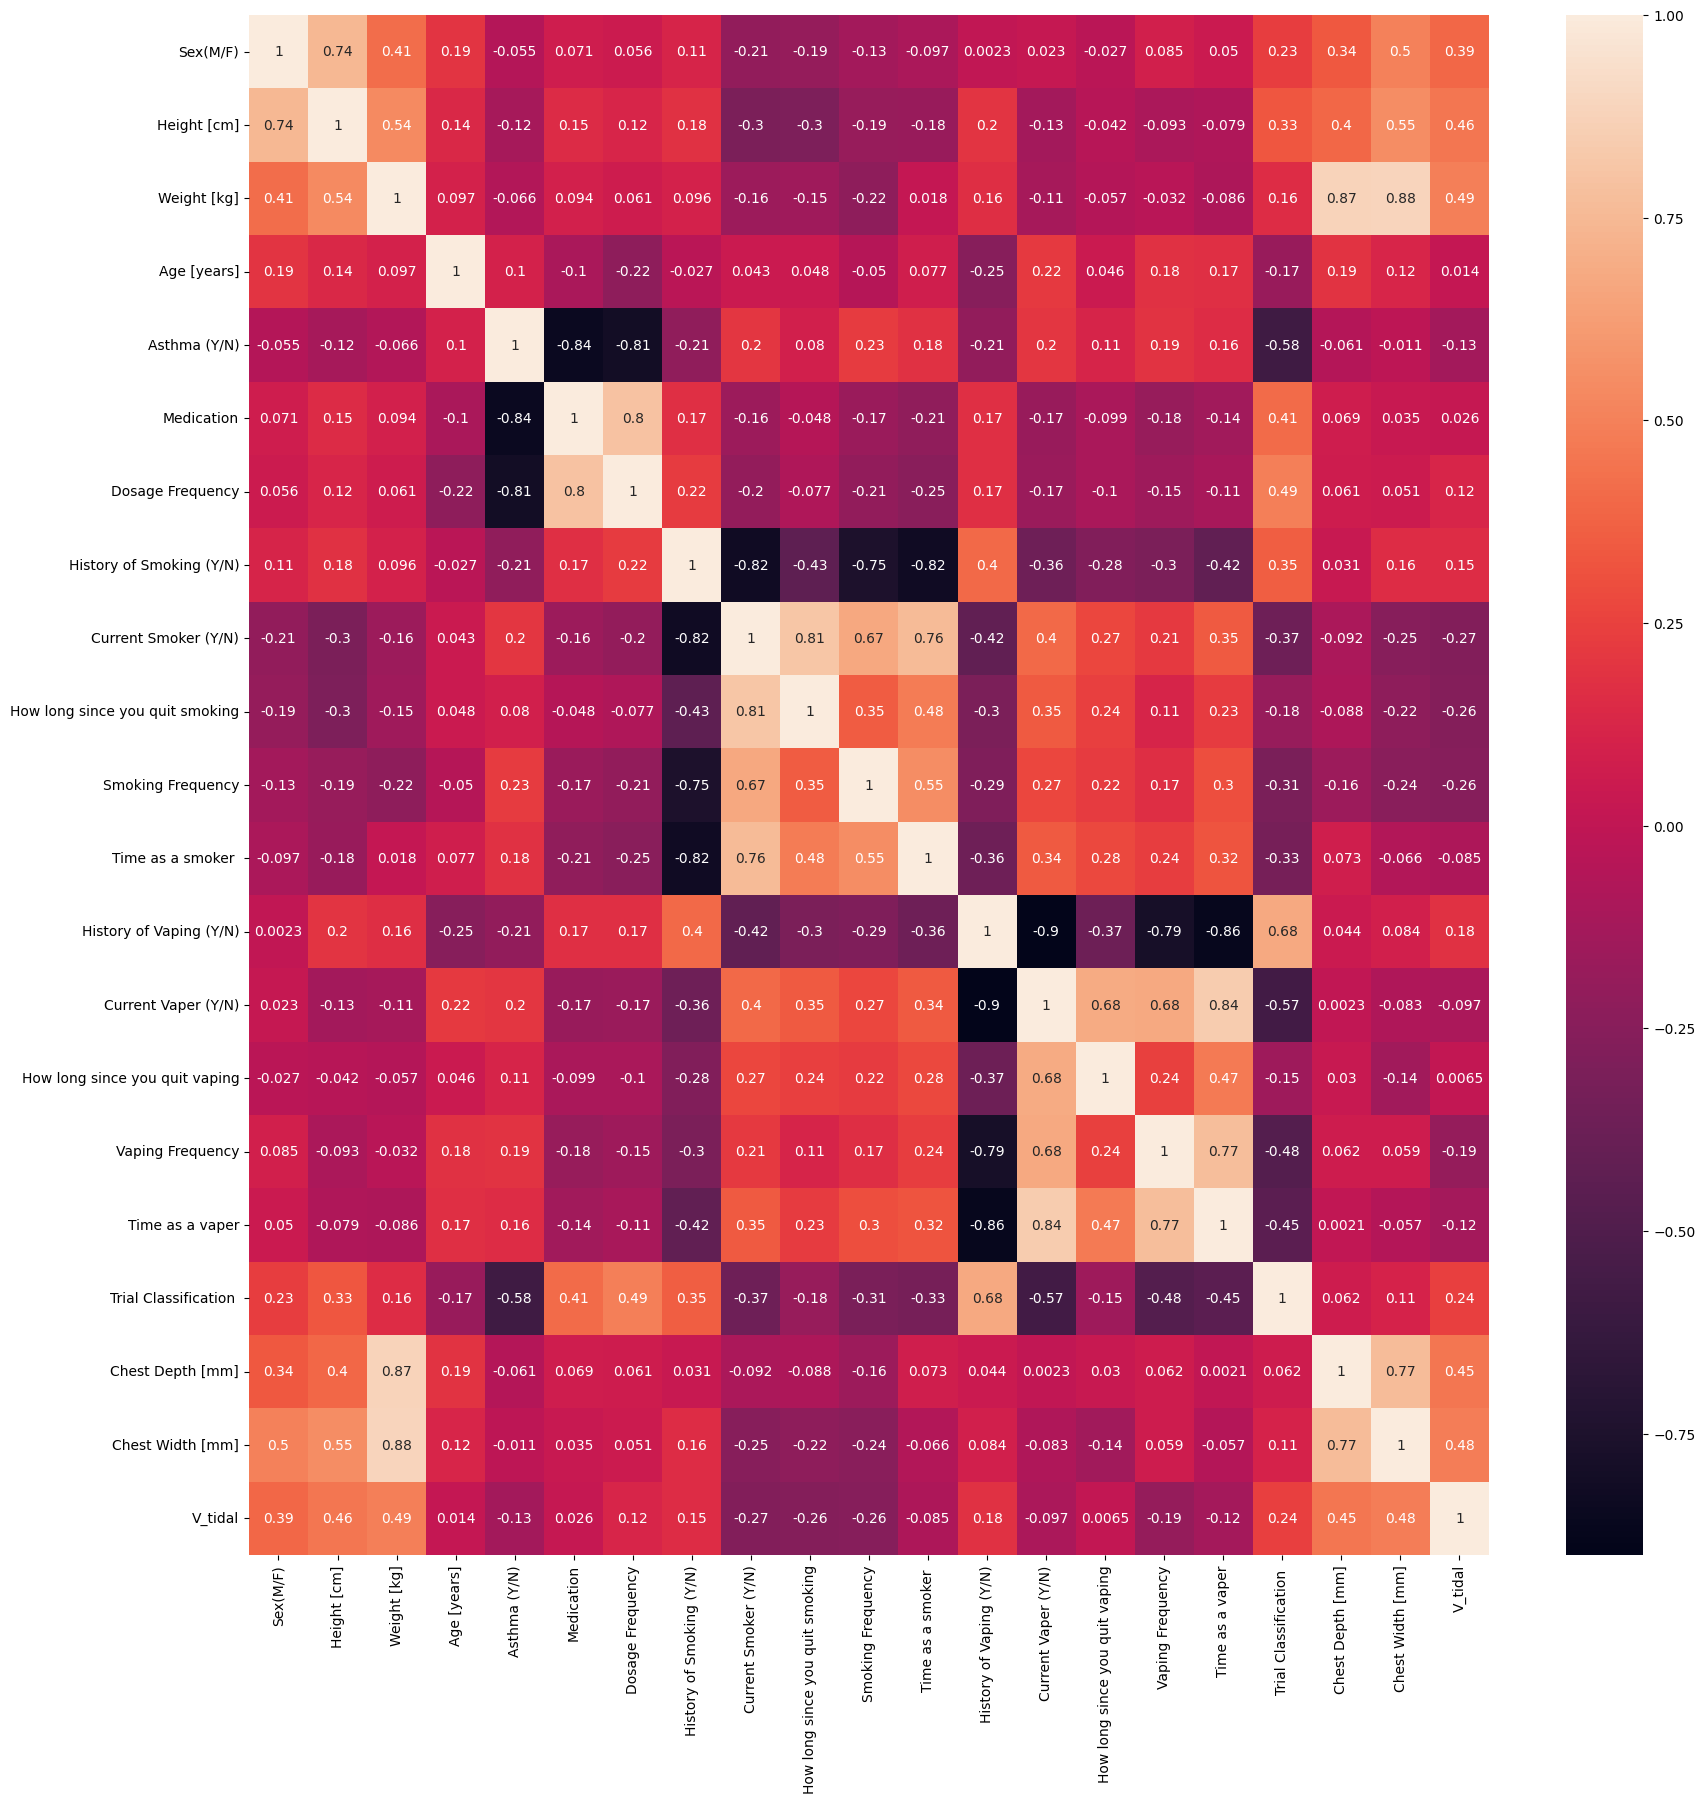

In [60]:
corr = df.corr(method= 'pearson')
plt.figure(figsize = (20,20))
sns.heatmap(corr,annot=True)

DATA AUGMENTATION

In [232]:
column_ranges = {
    'Sex(M/F)': (0,1),
    'Height [cm]': (165, 185),
    'Weight [kg]':(50,90),
    'Age [years]':(20,30),
    'Asthma (Y/N)':(0,1),
    'Medication':(0,11),
    'Dosage Frequency':(0,19),
    'History of Smoking (Y/N)':(0,1),
    'Current Smoker (Y/N)':(0,1),
    'How long since you quit smoking':(0,8),
    'Smoking Frequency':(0,21),
    'Time as a smoker ':(0,13),
    'History of Vaping (Y/N)':(0,1),
    'Current Vaper (Y/N)':(0,2),
    'How long since you quit vaping':(0,5),
    'Vaping Frequency':(0,28),
    'Time as a vaper':(0,12),
    'Trial Classification ':(0,7),
    'Chest Depth [mm]':(19,30),
    'Chest Width [mm]':(28,40),


}
data=df

def add_gaussian_noise(data, noise_level=0.01):
    noisy_data = data + noise_level * np.random.normal(size=data.shape)
    return noisy_data

def interpolate_data(data, num_samples):
    new_data = []
    for _ in range(num_samples):
        idx1, idx2 = np.random.choice(len(data), 2, replace=False)
        alpha = np.random.rand()
        new_point = alpha * data[idx1] + (1 - alpha) * data[idx2]
        new_data.append(new_point)
    return np.array(new_data)

def ensure_positive_integers_in_range(data, column_ranges):
    for column, (min_val, max_val) in column_ranges.items():
        data[column] = np.abs(data[column])  # Ensure positive values
        data[column] = data[column].round(0).astype(int)  # Convert to integers
        data[column] = np.clip(data[column], min_val, max_val)  # Constrain to range
    return data


original_data = data.values
noisy_data = add_gaussian_noise(original_data)
interpolated_data = interpolate_data(original_data, num_samples=340)

augmented_data = np.vstack([original_data, noisy_data, interpolated_data])

augmented_df = pd.DataFrame(augmented_data, columns=data.columns)

augmented_df = ensure_positive_integers_in_range(augmented_df, column_ranges)


<Axes: >

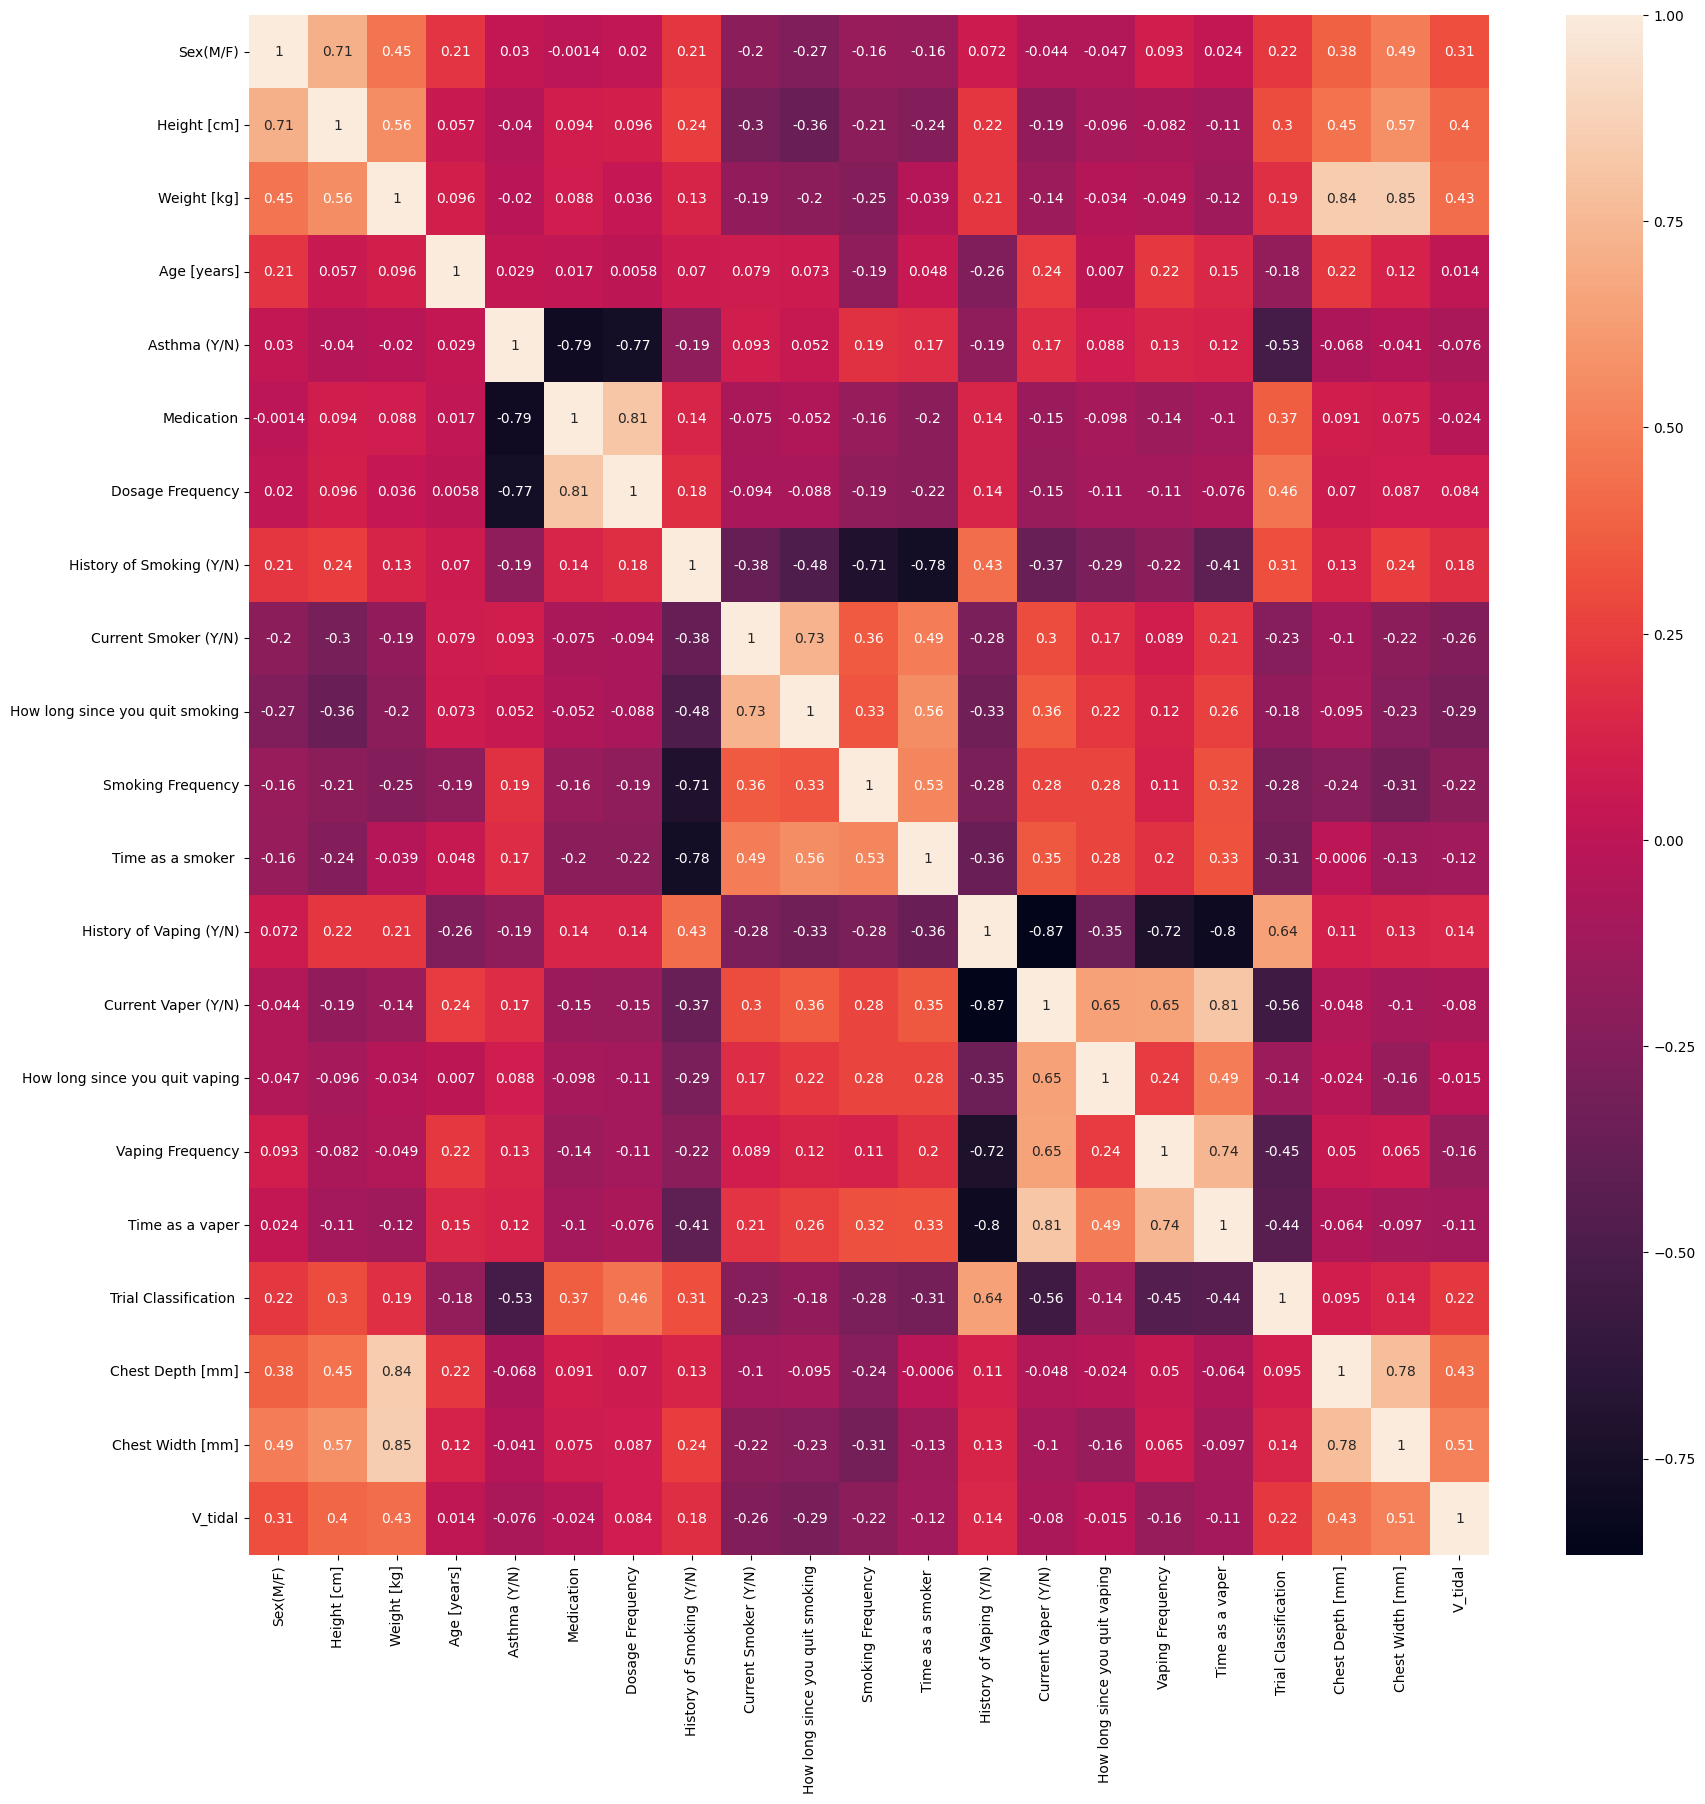

In [233]:
corr = augmented_df.corr(method= 'pearson')
plt.figure(figsize = (20,20))
sns.heatmap(corr,annot=True)

DATA SPILITTING AND SCALING

In [234]:
X=augmented_df.drop('V_tidal',axis=1).to_numpy()
Y=augmented_df['V_tidal'].to_numpy().reshape(-1,1)

#spiliting
x_train,x_test,y_train,y_test=tts(X,Y,test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

RandomForestRegressor

In [235]:
model1 = RandomForestRegressor()
model1.fit(x_train,y_train)

p1 = model1.predict(x_test)

<ipython-input-235-c8989fdafb38>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model1.fit(x_train,y_train)


Linear Regressor

In [236]:
model2=LR()
model2.fit(x_train,y_train)

predictions=model2.predict(x_test)

R2 Score

In [237]:
g=y_test.shape[0]
RSS1=mean_squared_error(y_test,predictions)*g
RSS2=mean_squared_error(y_test,p1)*g

TSS=np.sum(np.multiply((Y-Y.mean()),(Y-Y.mean())))

R2_1=1-(RSS1/TSS)
R2_2=1-(RSS2/TSS)

print("R2 score of LR model:",R2_1)
print("R2 score of RF model:",R2_2)

R2 score of LR model: 0.8832752571831907
R2 score of RF model: 0.9650998593655651
